In [9]:
#libraries
import pandas as pd
import numpy as np
import nltk
import re
import os
import codecs
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import datetime
from scipy.spatial.distance import cosine
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import string
import plotly.graph_objects as go # or plotly.express as px
import plotly.express as px

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tommi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tommi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# About Notebook

This notebook is to craete graphs from word counts from subsample of the NOW Data

1. First section contains two functions which can be used to generate graphs by each nation
2. Second section contains three functions to generate DataFrame for later graph use
3. Third section contains a function to create graph with plotly and use it to export files in format of html and png

In [51]:
#Directories and csv files for later use
directory = r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master\peace-speech-project-master\data\word_count'
csv_files = [s for s in os.listdir(directory) if ".csv" in s]

#Save_directory
save_dir = r'C:\Users\tommi\Documents\Columbia 2020 Fall\Capstone\peace-speech-project-master\peace-speech-project-master\data\word_count\by_state'
nation_list = {'peaceful': ['AU', 'CA', 'IE', 'NZ', 'SG',
                            'GB'],
              'non_peaceful': ['BD','KE', 'NG', 'PK', 'TZ'],
              'neutral':['GH', 'HK', 'IN', 'JM', 'MY', 'PH', 'ZA', 'LK', 'US']}

## 1. Create most frequent graphs by nation

In [20]:
#Auxillary function for graph 
def save_plot(df, save_dir, n):
    
    country_name = df['nation'][0]
    label_name = df['label'][0]
    img_dir = os.path.join(save_dir, country_name+ '_'+ label_name + '.jpg')
    
    words = df['Term'][0:n]
    counts = df['count'][0:n]
    
    x_pos = np.arange(len(words)) 
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= str(n) + ' most common ' + label_name  + ' lexicons in ' + country_name)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    
    plt.savefig(img_dir, bbox_inches='tight', dpi=500)

In [21]:
def save_three_graph(csv_file_directory):
    df = pd.read_csv(csv_file_directory)
    
    #Create three df for later graph and change index for later loop
    df_peace = df[df['label'] == 'peace'].copy()
    df_peace.index = np.arange(0, len(df_peace))
    df_conflict = df[df['label'] == 'conflict'].copy()
    df_conflict.index = np.arange(0, len(df_conflict))
    df_resilence = df[df['label'] == 'resilence'].copy()
    df_resilence.index = np.arange(0, len(df_resilence))
    
    #
    save_plot(df_peace, save_dir, 15)
    save_plot(df_conflict, save_dir, 15)
    save_plot(df_resilence, save_dir, 15)

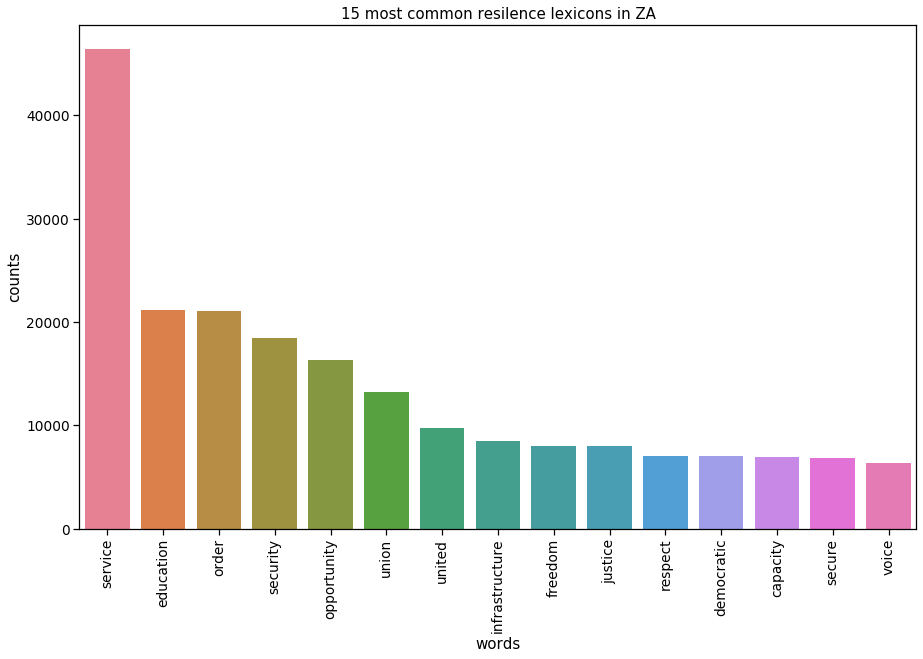

In [29]:
for csv_file in csv_files:
    csv_dir = os.path.join(directory, csv_file)
    save_three_graph(csv_dir)

## 2. Stacked bar chart (all nation)

In [22]:
def create_count_df(directory, csv_files, label = 'Total'):
    '''
    input:  directory: The directory of place where the count_dict_df locates
            csv_files: list of csv_files
            label: str, in choice of ['peace', 'conflict', 'resilence']
            
    output: pd.DataFrame: index is Term of words, columns are nation, cells are count of the Term
    '''
    #Create dataframe for later append
    df_result = pd.read_csv(os.path.join(directory, csv_files[0]))
    nation_name = df_result['nation'][0]
    df_result[nation_name] = df_result['count']
    
    if label == 'Total':
        pass
    else:
        df_result = df_result[df_result['label'] == label]
        df_result.index = np.arange(0, len(df_result))
        
    df_result = df_result.loc[:,['Term', 'AU']]
    df_result = df_result.set_index('Term')

    for i in range(1, len(csv_files)):
        #import df for join
        csv_dir = os.path.join(directory, csv_files[i])
        df_for_merge = pd.read_csv(csv_dir)
        
        #make changes on df for join
        nation_name = df_for_merge['nation'][0]
        df_for_merge[nation_name] = df_for_merge['count']
        parse_list = ['Term']
        parse_list.append(nation_name)
        
        if label == 'Total':
            pass
        else:
            df_for_merge = df_for_merge[df_for_merge['label'] == label]
            df_for_merge.index = np.arange(0, len(df_for_merge))
        
        df_for_merge = df_for_merge.loc[:, parse_list]

        #join df
        df_result = df_result.join(df_for_merge.set_index('Term'))

    df_result['Total'] = df_result.sum(axis = 1).values
    df_result = df_result.sort_values(by=['Total'], ascending = False)
    
    return df_result

In [23]:
def create_weight_df(directory, csv_files, label = 'Total'):
    '''
    input:  directory: The directory of place where the count_dict_df locates
            csv_files: list of csv_files
            label: str, in choice of ['peace', 'conflict', 'resilence']
            
    output: pd.DataFrame: index is Term of words, columns are nation, cells are Term_count/Total_count
    '''
    
    df_result = pd.read_csv(os.path.join(directory, csv_files[0]))
    nation_name = df_result['nation'][0]
    df_result[nation_name] = df_result['count']
    
    if label == 'Total':
        pass
    else:
        df_result = df_result[df_result['label'] == label]
        df_result.index = np.arange(0, len(df_result))
        
    df_result = df_result.loc[:,['Term', 'AU']]
    df_result = df_result.set_index('Term')
    df_result = df_result.divide(df_result.sum().values[0], axis =0)

    for i in range(1, len(csv_files)):
        #import df for join
        csv_dir = os.path.join(directory, csv_files[i])
        df_for_merge = pd.read_csv(csv_dir)
        
        #make changes on df for join
        nation_name = df_for_merge['nation'][0]
        df_for_merge[nation_name] = df_for_merge['count']
        parse_list = ['Term']
        parse_list.append(nation_name)
        
        if label == 'Total':
            pass
        else:
            df_for_merge = df_for_merge[df_for_merge['label'] == label]
            df_for_merge.index = np.arange(0, len(df_for_merge))
        
        df_for_merge = df_for_merge.loc[:, parse_list]
        df_for_merge = df_for_merge.set_index('Term')
        df_for_merge = df_for_merge.divide(df_for_merge.sum().values[0], axis =0)
        
        #join df
        df_result = df_result.join(df_for_merge)

    df_result['Total'] = df_result.sum(axis = 1).values
    df_result = df_result.sort_values(by=['Total'], ascending = False)
        
    return df_result

In [24]:
def create_df_by_state(df_result, nation_list):
    '''
    input: pd.DataFrame created from either weight or count
           nation_list: dict {str(state):list(nation)}
    output: pd.DataFrame, with Three states and Total
    '''
    df_copy = df_result.copy()
    df_copy['peaceful'] = df_copy.reindex(columns=nation_list['peaceful']).sum(axis = 1).values
    df_copy['non_peaceful'] = df_copy.reindex(columns=nation_list['non_peaceful']).sum(axis = 1).values
    df_copy['neutral'] = df_copy.reindex(columns=nation_list['neutral']).sum(axis = 1).values
    
    state_list = ['peaceful', 'non_peaceful', 'neutral']
    
    df_copy = df_copy.reindex(columns=state_list)
    df_copy['Total'] = df_copy.sum(axis = 1).values
    
    return df_copy

## 3. Create Graph and export

In [25]:
def create_stacked_bar_chart(df_result, n, label, method, state = False):
    '''
    input: df_result from create_count_df or create_weight_df
           n: number of words to show in the graph
    '''
    #truncate df by n and last Total column
    df_result = df_result.iloc[:n, :-1]
    
    data_list = []
    index_list = df_result.index
    for nation in df_result.columns:
        bar = go.Bar(name = nation, x = index_list, y = list(df_result[nation].values))
        data_list.append(bar)
        
    plot = go.Figure(data= data_list)
    plot.update_layout(barmode='stack')
                  
    plot.show()
    if state:
        img_name = 'state_' + label +'_' + method+'_result.png'
        html_name = 'state_' + label + '_' + method +'_result.html'
    else:
        img_name = label +'_' + method+'_result.png'
        html_name = label + '_' + method +'_result.html'
    plot.write_image(os.path.join(save_dir, img_name))
    plot.write_html(os.path.join(save_dir, html_name))

In [69]:
#Create Weight Data Frame
df_result = create_weight_df(directory, csv_files, label = 'resilence')

In [70]:
#Create Count Data Frame
#df_result =  create_count_df(directory, csv_files, label = 'resilence')

In [71]:
#Create Count Data Frame with count or weight
df_result = create_df_by_state(df_result, nation_list)
create_stacked_bar_chart(df_result, 20, label = 'resilence', method = 'weight', state = True)

In [96]:
create_stacked_bar_chart(df_result, 20, label = 'peace', method = 'weight')